In [27]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt 
from torchinfo import summary
from torchvision import transforms

In [28]:
from src import data_setup, engine
from src.helper_function import set_seeds, plot_loss_curves

In [29]:
#Splitting the data into train and test path.

train_dir = "data/train"
test_dir = "data/test"

![alt text](docs\img_size.svg)

In [30]:
#creating transforms 
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), #From table3 of ViT paper.
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [31]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size = 32 # Didn't use 4096 batch size due to GPU limitations. 
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d5cc11afb0>,
 ['pizza', 'steak', 'sushi'])

In [32]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

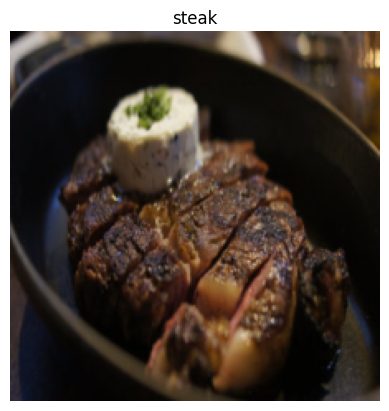

In [33]:
#visualizing single image

plt.imshow(image.permute(1,2,0)) 

"""
rearrange image dimensions to suit matplotlib 
[color_channels, height, width] -> [height, width, color_channels] 

"""

plt.title(class_names[label])
plt.axis(False);

The ViT architecture is comprised of several stages:

Patch + Position Embedding (inputs) - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.

Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.

Norm - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().

Multi-Head Attention - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().

MLP (or Multilayer perceptron) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendex B.1).


Transformer Encoder - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
MLP Head - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.


In [34]:
random_image_tensor = torch.randn(32,3,224,224)
random_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [35]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                    in_channels:int=3,
                    patch_size:int=16,
                    embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                    end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1)

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


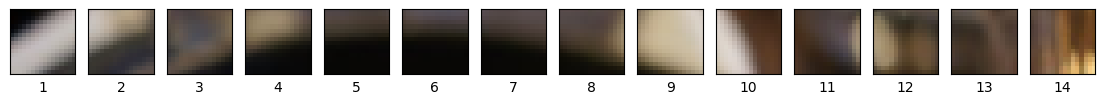

In [36]:
img_size = 224
patch_size = 16
image_permuted = image.permute(1, 2, 0)
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [37]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(random_image_tensor)

print(f"Input shape: {random_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape}")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768])


![alt text](docs\d_model.svg)

In [38]:
transformer_encoder_layer = nn.TransformerEncoderLayer(nhead=12,
                                                        d_model=768,
                                                        dim_feedforward=3072,
                                                        dropout=0.1,
                                                        batch_first=True,
                                                        norm_first=True)
from torchinfo import summary
summary(model=transformer_encoder_layer)

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
├─Linear: 1-2                                      2,362,368
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      2,360,064
├─LayerNorm: 1-5                                   1,536
├─LayerNorm: 1-6                                   1,536
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

This is the architecture of the model mentioned in the Vit paper. The problem is we need stack the 12 transformer encoder block one above the other. We use pytorch for that too. :)


In [39]:
transformer_encoder = nn.TransformerEncoder(num_layers=12,
                                            encoder_layer=transformer_encoder_layer)

summary(model=transformer_encoder)

c:\Users\heysr\anaconda3\envs\pytorch_venv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          2,362,368
│    │    └─Linear: 3-2                                      2,362,368
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      2,360,064
│    │    └─LayerNorm: 3-5                                   1,536
│    │    └─LayerNorm: 3-6                                   1,536
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          2,362,368
│    │    └─Linear: 3-10                                     2,36

#### Putting it all together to built the Vision Transformer Architecture

### Class token

![alt text](docs\class_tokens.svg)

### Positional embedding

![alt text](docs\pos_embedding.svg)

In [40]:
class ViT(nn.Module):
    def __init__(self,
                img_size = 224,
                in_channels=3, #table 3 
                patch_size = 16, 
                embedding_dim = 768,
                dropout= 0.1,
                mlp_size = 3072,
                num_transformers_layers = 12,
                num_heads = 12,
                num_classes=1000):
        super().__init__()
        
        assert img_size % patch_size == 0 , "Image size should be divisible by patch size"
        
        #create patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)
        
        #create class token 
        self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                        requires_grad=True)
        
        
        #create positional embedding
        num_patches = (img_size * img_size) // patch_size ** 2 # N= HW/p*3
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1 ,embedding_dim))
        
        
        #create patch + positional embedding dropout 
        self.embedding_dropout = nn.Dropout(p=dropout)
        
        
        #create stacked Transformer Encoder layes
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer= nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                    activation='gelu',
                                                                                                    batch_first=True,
                                                                                                    norm_first=True,
                                                                                                    nhead=num_heads,
                                                                                                    dim_feedforward=mlp_size),
                                                                                                    num_layers=num_transformers_layers)
        
        
        # create MLP heads
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                        out_features=num_classes)
        )
        
    def forward(self, x):
        
        #batch size
        batch_size = x.shape[0]
        
        #patch embedding
        x =  self.patch_embedding(x)
        
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)
        
        # Add positional embedding to patch embedding with class token
        x = self.positional_embedding + x
        
        # droput on patch + positional embedding
        x = self.embedding_dropout(x)
        
        # Pass embedding through Transformer Encoder stack 
        x = self.transformer_encoder(x)
        
        # Pass 0th index of x through MLP head
        x = self.mlp_head(x[:,0])
        
        return x 
        

In [41]:
len(class_names)

3

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [43]:
demo_img = torch.randn(1,3,224,224).to(device)
print(demo_img.shape)
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[-0.2702,  0.0799, -0.1457]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [44]:
summary(model=vit,
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

Lets copy all the code to python file. (vit.py)

In [45]:
%%writefile vit.py

import torch 
import torch.nn as nn

class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                    in_channels:int=3,
                    patch_size:int=16,
                    embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                    end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1)






class ViT(nn.Module):
    def __init__(self,
                img_size = 224,
                in_channels=3, #table 3 
                patch_size = 16, 
                embedding_dim = 768,
                dropout= 0.1,
                mlp_size = 3072,
                num_transformers_layers = 12,
                num_heads = 12,
                num_classes=1000):
        super().__init__()
        
        assert img_size % patch_size == 0 , "Image size should be divisible by patch size"
        
        #create patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)
        
        #create class token 
        self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                        requires_grad=True)
        
        
        #create positional embedding
        num_patches = (img_size * img_size) // patch_size ** 2 # N= HW/p*3
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1 ,embedding_dim))
        
        
        #create patch + positional embedding dropout 
        self.embedding_dropout = nn.Dropout(p=dropout)
        
        
        #create stacked Transformer Encoder layes
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer= nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                    activation='gelu',
                                                                                                    batch_first=True,
                                                                                                    norm_first=True,
                                                                                                    nhead=num_heads,
                                                                                                    dim_feedforward=mlp_size),
                                                                                                    num_layers=num_transformers_layers)
        
        
        # create MLP heads
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                        out_features=num_classes)
        )
        
    def forward(self, x):
        
        #batch size
        batch_size = x.shape[0]
        
        #patch embedding
        x =  self.patch_embedding(x)
        
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)
        
        # Add positional embedding to patch embedding with class token
        x = self.positional_embedding + x
        
        # droput on patch + positional embedding
        x = self.embedding_dropout(x)
        
        # Pass embedding through Transformer Encoder stack 
        x = self.transformer_encoder(x)
        
        # Pass 0th index of x through MLP head
        x = self.mlp_head(x[:,0])
        
        return x 
        

Overwriting vit.py


In [46]:
from vit import ViT
vit_model = ViT()
summary(model=vit_model,input_size=(1,3,224,224))

c:\Users\heysr\anaconda3\envs\pytorch_venv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

___________________________

### Training using Pretrained ViT model weights.

In [47]:
import torchvision 
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

vit_transforms = vit_weights.transforms()
print(vit_transforms)

#freeze layers 
for param in pretrained_vit.parameters():
    param.requires_grad = False

embedding_dim = 768
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
            out_features=len(class_names))
)

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [48]:
#getting the data
train_dir_for_pretrained = 'data/train'
test_dir_for_pretrained = 'data/test'

#preprocess the data
vit_transforms = vit_weights.transforms()
train_dataloader_pretrained , test_dataloader_pretrained , class_names = data_setup.create_dataloaders(train_dir=train_dir_for_pretrained,
                                                                                                        test_dir=test_dir_for_pretrained,
                                                                                                        batch_size=1024,
                                                                                                        transform=vit_transforms
                                                                                                        )

In [49]:
test_dataloader_pretrained , train_dataloader_pretrained , class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d5ce8ede40>,
 ['pizza', 'steak', 'sushi'])

In [51]:
#Let's train the data

set_seeds = ()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                                lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_result = engine.train(model=pretrained_vit,
                                    train_dataloader=train_dataloader_pretrained,
                                    test_dataloader=test_dataloader_pretrained,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=10,
                                    device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from src.helper_function import plot_loss_curves
plot_loss_curves(pretrained_vit_result)

ModuleNotFoundError: No module named 'helper_function'